## Multivariate autoregressive model example

In this case study we analyze multivariate time series using generic linear stochastic dynamical systems models. 
We will use these models to analyze multispecies time series and extract information on time series interactions and forcing.

The model we will analyze is given as 

$$ \mathbf{x}(t+1) = \mathbf{\Phi} \mathbf{x}(t) + \mathbf{e}(t) $$

where $\mathbf{x}(t)$ is a multivariate time series at time $t$, $\mathbf{\Phi}$ is the linear dynamics matrix, and $\mathbf{e}(t)$ is a realization of a stochastic variable, assumed here multivariate normal with mean vector zero and covariance matrix, $\mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$.

In general, we can think of this model as a first order approximation to the dynamics of a more general multivariate dynamical system. 
In this context, the matrix $\mathbf{\Phi}$ would represent the Jacobian matrix, containing information on the discretized partial derivatives of each state variable with respect to each of the others. 
The matrix $\mathbf{\Sigma}$ contains information on the magnitude of stochastic forcing as well as correlations among the variables responses.

In [1]:
using StanSample, Statistics, PyPlot, Random, Distributions, LinearAlgebra

To explore this model we will first simulate some data

The procedure below uses some linear algebra (specifically the $QR$ decomposition) to generate a random matrix that will stable, i.e. that simulated time series won't blow-up.
We do so by making the eigenvalues of the random matrix lie between 0 and 1.

In [2]:
p = 3;
SIGMA = diagm(rand(Uniform(),p))

eig = rand(Uniform(),p)
Z = rand(Normal(),p,p)
Q,R = qr(Z)
d = diag(R)
ph = d ./ abs.(d)
O = Q * diagm(ph)
PHI = transpose(O) * diagm(eig) * O;

We simulate time series given the specified parameters. 
Notice we are drawing a multivariate normal realization every time step with mean zero and covariance matrix `SIGMA`.

In [3]:
T = 200
y0 = rand(Normal(),p)
Y = zeros(p,T)
Y[:,1] = y0

for i in 2:T
    Y[:,i] = PHI * Y[:,i-1] + rand(MvNormal(zeros(3),SIGMA))
end

Plot the system

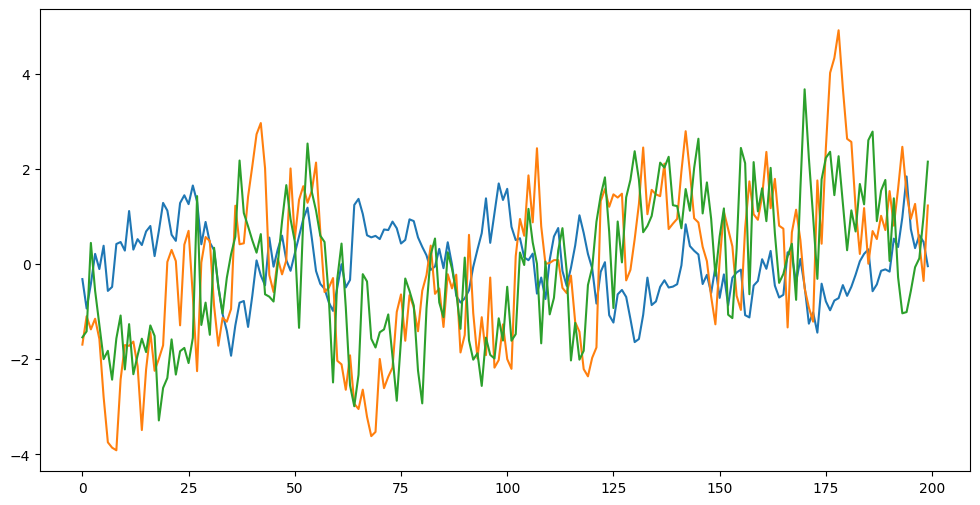

In [4]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(transpose(Y));

The Stan code below implements the first order multivariate model.
As per usual, we pass Stan the data and its dimensions in the `data` block.
In the `parameters` block, we define the linear dynamics matrix `PHI` which has as many rows and columns as there are time series.
In this case we assume the covariance matrix is of the form

$$ \mathbf{\Sigma} = \begin{bmatrix} \sigma_{1,1} & 0 & \cdots & 0\\
                                    0 & \sigma_{2,2} & \ddots & \vdots \\
                                    \vdots & \ddots & \ddots & \vdots \\
                                    0 & \cdots & \cdots & \sigma_{p,p} \end{bmatrix}   $$
                                    
which means that each species in the mulispecies time series responds to the environment independently.

In [5]:
mod_code = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    Y[,1] ~ normal(init, sigma);           //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma); //conditional predictive distribution
    }
}";

Organize the data for Stan

In [6]:
data = Dict("p" => p, "T" => T, "Y" => Y)

Dict{String,Any} with 3 entries:
  "Y" => [-0.314795 -0.9328 … 0.466197 -0.0429541; -1.69308 -1.09569 … -0.35376…
  "T" => 200
  "p" => 3

Compile the model

In [7]:
sm = SampleModel("MV_AR", mod_code)


/tmp/jl_F4Xag2/MV_AR.stan updated.


  name =                    "MV_AR"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/tmp/jl_F4Xag2"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


Perform mcmc

In [8]:
(sample_file, log_file) = stan_sample(sm, data=data, n_chains = 4);

In [9]:
chns = read_samples(sm)

Object of type Chains, with data of type 1000×22×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = PHI.1.1, PHI.2.1, PHI.3.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.1.3, PHI.2.3, PHI.3.3, sigma.1, sigma.2, sigma.3, init.1, init.2, init.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean      │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64   │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼───────────┼───────────┼─────────────┼─────────────┤
│ 1   │ PHI.1.1    │ 0.669088  │ 0.0455349 │ 0.00071997  │ 0.00068174  │
│ 2   │ PHI.2.1    │ 0.0221374 │ 0.0980927 │ 0.00155098  │ 0.00114896  │
│ 3   │ PHI.3.1    │ -0.113038 │ 0.107783  │ 0.00170419  │ 0.00172578  │
│ 4   │ PHI.1.2    │ 0.0732231 │ 0.0214182 │ 0.0

In [10]:
ESS = ess(chns)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ PHI.1.1    │ 4573.63 │ 0.999465 │
│ 2   │ PHI.2.1    │ 5437.25 │ 0.999604 │
│ 3   │ PHI.3.1    │ 5702.6  │ 0.999662 │
│ 4   │ PHI.1.2    │ 4077.66 │ 1.00047  │
│ 5   │ PHI.2.2    │ 4442.0  │ 1.00005  │
│ 6   │ PHI.3.2    │ 4498.62 │ 0.999166 │
│ 7   │ PHI.1.3    │ 3876.33 │ 1.00012  │
│ 8   │ PHI.2.3    │ 4005.8  │ 0.9996   │
│ 9   │ PHI.3.3    │ 4319.24 │ 0.999952 │
│ 10  │ sigma.1    │ 5954.48 │ 0.999182 │
│ 11  │ sigma.2    │ 4921.33 │ 0.999419 │
│ 12  │ sigma.3    │ 5924.15 │ 0.99967  │
│ 13  │ init.1     │ 5498.44 │ 0.999827 │
│ 14  │ init.2     │ 5465.13 │ 0.999322 │
│ 15  │ init.3     │ 5951.57 │ 0.999501 │

### Investigating the stochastic forcing matrix
Here we relax the assumption of independent forcing and specify a covariance matrix with non zero off diagonal elements

$$ \mathbf{\Sigma} = \begin{bmatrix} \sigma_{1,1} & \sigma_{1,2} & \cdots & \sigma_{1,p}\\
                                    \sigma_{2,1} & \sigma_{2,2} & \ddots & \vdots \\
                                    \vdots & \ddots & \ddots & \vdots \\
                                    \sigma_{p,1} & \cdots & \cdots & \sigma_{p,p} \end{bmatrix}   $$

Generate a random matrix that is a proper covariance matrix, i.e. it is positive semi-definite

In [11]:
A = rand(Uniform(),p,p) .* 2 .- 1
SIGMA2 = transpose(A) * A

3×3 Array{Float64,2}:
  1.74167    0.614095  -0.103883
  0.614095   1.18573   -0.282557
 -0.103883  -0.282557   0.657597

Simulate synthetic time series with the covariance matrix above

In [12]:
T = 200
y20 = rand(Normal(),p)
Y2 = zeros(p,T)
Y2[:,1] = y20

for i in 2:T
    Y2[:,i] = PHI * Y2[:,i-1] + rand(MvNormal(zeros(3),SIGMA2))
end

Plot the time series

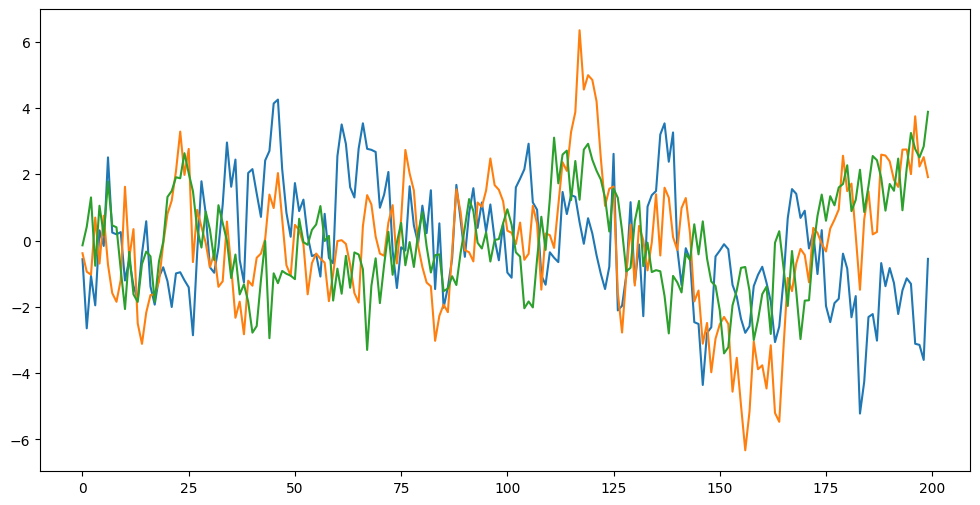

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(transpose(Y2));

We estimate the full covariance in the Stan code below.
We make use of the very handy parameter type `cov_matrix` which maintains the positive semi-definite requirement throughout the mcmc iterations.

In [14]:
mod_code_cov = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    cov_matrix[p] SIGMA; //co-variance matrix of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    Y[,1] ~ multi_normal(init, SIGMA);           //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ multi_normal(PHI*Y[,i-1],SIGMA); //conditional predictive distribution
    }
}";

Package the data

In [15]:
data2 = Dict("p" => p, "T" => T, "Y" => Y2)

Dict{String,Any} with 3 entries:
  "Y" => [-0.561975 -2.64879 … -3.6013 -0.552763; -0.383535 -0.940461 … 2.518 1…
  "T" => 200
  "p" => 3

Compile the model

In [16]:
sm2 = SampleModel("MV_AR2", mod_code_cov)


/tmp/jl_WFhAeO/MV_AR2.stan updated.


  name =                    "MV_AR2"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/tmp/jl_WFhAeO"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


Perform mcmc

In [17]:
(sample_file, log_file) = stan_sample(sm2, data=data2, n_chains = 4);

In [18]:
chns2 = read_samples(sm2)

Object of type Chains, with data of type 1000×28×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = PHI.1.1, PHI.2.1, PHI.3.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.1.3, PHI.2.3, PHI.3.3, SIGMA.1.1, SIGMA.2.1, SIGMA.3.1, SIGMA.1.2, SIGMA.2.2, SIGMA.3.2, SIGMA.1.3, SIGMA.2.3, SIGMA.3.3, init.1, init.2, init.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean      │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64   │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼───────────┼───────────┼─────────────┼─────────────┤
│ 1   │ PHI.1.1    │ 0.618489  │ 0.0620151 │ 0.000980545 │ 0.00114645  │
│ 2   │ PHI.2.1    │ 0.0863064 │ 0.0533814 │ 0.000844034 │ 0.000965862 │
│ 3   │ PHI.3.1    │ -0.249779 │ 0.0394991 │ 0.00

In [19]:
ESS2 = ess(chns2)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ PHI.1.1    │ 2975.03 │ 0.999877 │
│ 2   │ PHI.2.1    │ 2887.46 │ 1.00092  │
│ 3   │ PHI.3.1    │ 3263.89 │ 0.999958 │
│ 4   │ PHI.1.2    │ 2598.69 │ 0.999637 │
│ 5   │ PHI.2.2    │ 2797.31 │ 1.00123  │
│ 6   │ PHI.3.2    │ 3094.62 │ 0.999368 │
│ 7   │ PHI.1.3    │ 2604.33 │ 1.00023  │
│ 8   │ PHI.2.3    │ 2805.67 │ 1.00077  │
│ 9   │ PHI.3.3    │ 3127.65 │ 0.999654 │
│ 10  │ SIGMA.1.1  │ 4780.86 │ 1.00006  │
│ 11  │ SIGMA.2.1  │ 3686.8  │ 0.999484 │
│ 12  │ SIGMA.3.1  │ 4509.26 │ 0.999462 │
│ 13  │ SIGMA.1.2  │ 3686.8  │ 0.999484 │
│ 14  │ SIGMA.2.2  │ 4154.59 │ 0.999363 │
│ 15  │ SIGMA.3.2  │ 4792.97 │ 0.999933 │
│ 16  │ SIGMA.1.3  │ 4509.26 │ 0.999462 │
│ 17  │ SIGMA.2.3  │ 4792.97 │ 0.999933 │
│ 18  │ SIGMA.3.3  │ 4778.6  │ 1.00015  │
│ 19  │ init.1     │ 4825.03 │ 0.999399 │
│ 20  │ init.2     │ 4242.92 │ 0.99956  │
│ 21  │ init.3     │ 4900.1  

### Incorporating informative priors on the structure of the dynamics

Here we will impose informative priors on particular elements of the $\mathbf{\Phi}$

The Stan code below imposes the following structure on $\mathbf{\Phi}$:

$$ \mathbf{\Phi} = \begin{bmatrix} \phi_{1,1} & \phi_{1,2} & 0 \\ 
                                \phi_{2,1} & \phi_{2,2} & \phi_{2,3}\\
                                0       & \phi_{3,2} & \phi_{3,3} \end{bmatrix} $$
                                
The prior assumption is that $\phi_{1,3}$ and $\phi_{3,1}$ have means of zero and a very small standard deviation of $10^{-3}$

In [20]:
mod_code_D_struc = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;               //dynamics matrix
    vector<lower=1E-15>[p] sigma;  //variances of stochastic forcing
    vector[p] init;                //mean of initial conditions as parameter vector
}
model{
    PHI[1,3] ~ normal(0,1E-3);
    PHI[3,1] ~ normal(0,1E-3);

    Y[,1] ~ normal(init, sigma);           //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma); //conditional predictive distribution
    }
}";

In [21]:
sm3 = SampleModel("MV_AR3", mod_code_D_struc)


/tmp/jl_j9ZLc4/MV_AR3.stan updated.


  name =                    "MV_AR3"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/tmp/jl_j9ZLc4"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [22]:
(sample_file, log_file) = stan_sample(sm3, data=data, n_chains = 4);

In [23]:
chns3 = read_samples(sm3)

Object of type Chains, with data of type 1000×22×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = PHI.1.1, PHI.2.1, PHI.3.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.1.3, PHI.2.3, PHI.3.3, sigma.1, sigma.2, sigma.3, init.1, init.2, init.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean         │ std         │ naive_se    │ mcse        │
│     │ Symbol     │ Float64      │ Float64     │ Float64     │ Float64     │
├─────┼────────────┼──────────────┼─────────────┼─────────────┼─────────────┤
│ 1   │ PHI.1.1    │ 0.770901     │ 0.0487287   │ 0.000770469 │ 0.000695118 │
│ 2   │ PHI.2.1    │ 0.020422     │ 0.0964789   │ 0.00152547  │ 0.00129851  │
│ 3   │ PHI.3.1    │ 1.07633e-5   │ 0.000997846 │ 1.57773e-5  │ 1.38158e-5  │
│ 4   │ PHI.1.2   

In [24]:
ESS3 = ess(chns3)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ PHI.1.1    │ 6076.22 │ 1.00071  │
│ 2   │ PHI.2.1    │ 5849.76 │ 0.999592 │
│ 3   │ PHI.3.1    │ 4175.1  │ 1.00024  │
│ 4   │ PHI.1.2    │ 7068.52 │ 1.00046  │
│ 5   │ PHI.2.2    │ 4715.48 │ 1.00033  │
│ 6   │ PHI.3.2    │ 4465.09 │ 0.999467 │
│ 7   │ PHI.1.3    │ 4087.88 │ 0.999646 │
│ 8   │ PHI.2.3    │ 4598.74 │ 0.999345 │
│ 9   │ PHI.3.3    │ 4700.57 │ 0.999376 │
│ 10  │ sigma.1    │ 6763.94 │ 0.999217 │
│ 11  │ sigma.2    │ 6535.7  │ 0.999366 │
│ 12  │ sigma.3    │ 6446.44 │ 0.999451 │
│ 13  │ init.1     │ 7187.74 │ 0.999414 │
│ 14  │ init.2     │ 6398.89 │ 0.99923  │
│ 15  │ init.3     │ 6196.71 │ 0.999461 │

In [25]:
mod_code_D_struc2 = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    real phi12;               //dynamics matrix
    real phi23;
    vector[p] phi_diag;
    vector<lower=1E-15>[p] sigma;  //variances of stochastic forcing
    vector[p] init;                //mean of initial conditions as parameter vector
}
transformed parameters{
    matrix[p,p] PHI;
    PHI[1,3] = 0;
    PHI[3,1] = 0;
    PHI[1,2] = phi12;
    PHI[2,1] = phi12;
    PHI[2,3] = phi23;
    PHI[3,2] = phi23;
    for(i in 1:p){
    PHI[i,i] = phi_diag[i];
    }
}
model{
    Y[,1] ~ normal(init, sigma);           //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma); //conditional predictive distribution
    }
}";

In [26]:
sm4 = SampleModel("MV_AR4", mod_code_D_struc2)


/tmp/jl_AE3Q5c/MV_AR4.stan updated.


  name =                    "MV_AR4"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/tmp/jl_AE3Q5c"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [27]:
(sample_file, log_file) = stan_sample(sm4, data=data, n_chains = 4);

In [28]:
chns4 = read_samples(sm4)

Object of type Chains, with data of type 1000×27×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = phi12, phi23, phi_diag.1, phi_diag.2, phi_diag.3, sigma.1, sigma.2, sigma.3, init.1, init.2, init.3, PHI.1.1, PHI.2.1, PHI.3.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.1.3, PHI.2.3, PHI.3.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean        │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64     │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼─────────────┼───────────┼─────────────┼─────────────┤
│ 1   │ phi12      │ -0.00547849 │ 0.0205492 │ 0.000324911 │ 0.000274437 │
│ 2   │ phi23      │ 0.238626    │ 0.0358649 │ 0.000567074 │ 0.000483114 │
│ 3   │ phi_diag.1 │ 0.77258     │ 0.0476016 │ 0.000752647 │ 

In [29]:
ESS4 = ess(chns4)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ phi12      │ 6481.28 │ 0.999252 │
│ 2   │ phi23      │ 4920.64 │ 0.999855 │
│ 3   │ phi_diag.1 │ 6248.42 │ 0.999905 │
│ 4   │ phi_diag.2 │ 5944.34 │ 0.99988  │
│ 5   │ phi_diag.3 │ 5435.68 │ 0.9998   │
│ 6   │ sigma.1    │ 7221.83 │ 0.999572 │
│ 7   │ sigma.2    │ 6690.67 │ 0.999472 │
│ 8   │ sigma.3    │ 6508.06 │ 0.999248 │
│ 9   │ init.1     │ 6856.04 │ 0.999259 │
│ 10  │ init.2     │ 6996.67 │ 0.999896 │
│ 11  │ init.3     │ 8134.1  │ 0.999275 │
│ 12  │ PHI.1.1    │ 6248.42 │ 0.999905 │
│ 13  │ PHI.2.1    │ 6481.28 │ 0.999252 │
│ 14  │ PHI.3.1    │ NaN     │ NaN      │
│ 15  │ PHI.1.2    │ 6481.28 │ 0.999252 │
│ 16  │ PHI.2.2    │ 5944.34 │ 0.99988  │
│ 17  │ PHI.3.2    │ 4920.64 │ 0.999855 │
│ 18  │ PHI.1.3    │ NaN     │ NaN      │
│ 19  │ PHI.2.3    │ 4920.64 │ 0.999855 │
│ 20  │ PHI.3.3    │ 5435.68 │ 0.9998   │